# Fixed Income Derivatives - SABR Model Example

In the SABR model, the forward rate denoted $F_t$, typically a forward par swap rate, follows a stochastic
process with stochastic volatility $\sigma_t$. The joint dynamics of $F_t$ and $\sigma_t$
$$
\begin{split}
dF_t &= \sigma_t F_t^\beta dW_t^{(1)}, \qquad F(0) = F_0 \\
d\sigma_t &= \upsilon \sigma_t dW_t^{(2)}, \qquad \sigma(0) = \sigma_0 \\
dW_t^{(1)} dW_t^{(2)} &= \rho dt
\end{split}
$$
where $\sigma_0 > 0$, $0 < \beta \geq 1$, $\upsilon > 0$ and $−1 < \rho < 1$ are parameters of the model.

Zero coupon bond prices observed from market data are given in the below table. 
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
T & 0.50 & 1.00 & 1.50 & 2.00 & 2.50 & 3.00 & 3.50 \\
\hline
p(0, T) & 0.98429046 & 0.96633686 & 0.94690318 & 0.92655036 & 0.90568659 & 0.8840647 & 0.86352084 \\
\hline
T & 4.00 & 4.50 & 5.00 & 5.50 & 6.00 & 6.50 & 7.00 \\
\hline
p(0, T) & 0.84257919 & 0.82188628 & 0.80151436 & 0.78151217 & 0.76191149 & 0.74273188 & 0.72398415 \\
\hline
\end{array}
$$
Also, we can observe prices of 2Y5Y payer swaptions for a number of strike offsets.
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
K_{\text{offset}} (\text{bp}) & -300 & -250 & -200 & -150 & -100 & -50 & \text{ATMF} \\
\hline
\Pi_{\text{swaption}} & 0.12301549 & 0.10339456 & 0.08421278 & 0.06567338 & 0.04843543 & 0.03300976 & 0.02048677 \\
\hline
K_{\text{offset}} (\text{bp}) & 50 & 100 & 150 & 200 & 250 & 300 & - \\
\hline
\Pi_{\text{swaption}} & 0.01178334 & 0.00648577 & 0.00361682 & 0.00215934 & 0.00137503 & 0.00093634 & - \\
\hline
\end{array}
$$


In [1]:
import sys
import os
# add the directory
sys.path.append(os.path.abspath("../../Files"))
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import numpy as np
from scipy.optimize import minimize
from scipy.special import ndtr
import matplotlib.pyplot as plt

# import own module
import fixed_income_derivatives_E2024 as fid
import plotting as plot

%load_ext autoreload
%autoreload 2

## Problem 1 - The Implied Volatility Smile
Compute the 2Y5Y par swap rate which serves as the underlying asset of the swaption by first computing
the corresponding accrual factor $S_{swap}$

#### (a) Report the 2Y 5Y forward par swap rate.

In [2]:
alpha = 0.5
idx_exer, idx_mat = 4, 14
S_swap = 0
p = np.array([1, 0.98429046, 0.96633686, 0.94690318, 0.92655036, 0.90568659, 0.88460647, 0.86352084, 0.84257919, 0.82188628, 0.80151436, 0.78151217, 0.76191149, 0.74273188, 0.72398415])
for i in range(idx_exer+1,idx_mat + 1):
    S_swap += alpha*p[i]
R_swap = (p[idx_exer] - p[idx_mat])/S_swap
print(f"accrual factor: {S_swap}, 2Y5Y par swap rate: {R_swap}")

accrual factor: 4.06496671, 2Y5Y par swap rate: 0.04983219407472096


#### (b) Compute Black implied volatilities for all strikes and plot these as a function of $K_{offset}$

In [3]:
T_max = 7
M = int(round(T_max/alpha)+1)
T = np.array([i*alpha for i in range(0,M)])
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
price_market = np.array([0.12301549, 0.10339456, 0.08421278, 0.06567338, 0.04843543, 0.03300976, 0.02048677, 0.01173834, 0.00648577, 0.00361682, 0.00215934, 0.00137503, 0.00093634])
N_swaption = len(K_swaption_offset)
K, iv_market = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv_market[i] = fid.black_swaption_iv(price_market[i],T[idx_exer],K[i],S_swap,R_swap,type = "call", iv0 = 0.25, max_iter = 1000, prec = 1.0e-12)
print(f'market implied volatility: \n{iv_market}')

market implied volatility: 
[0.37271288 0.32282708 0.28265711 0.24785851 0.22072556 0.19726113
 0.17974193 0.16969789 0.16614408 0.16689728 0.17143419 0.17752206
 0.18457536]


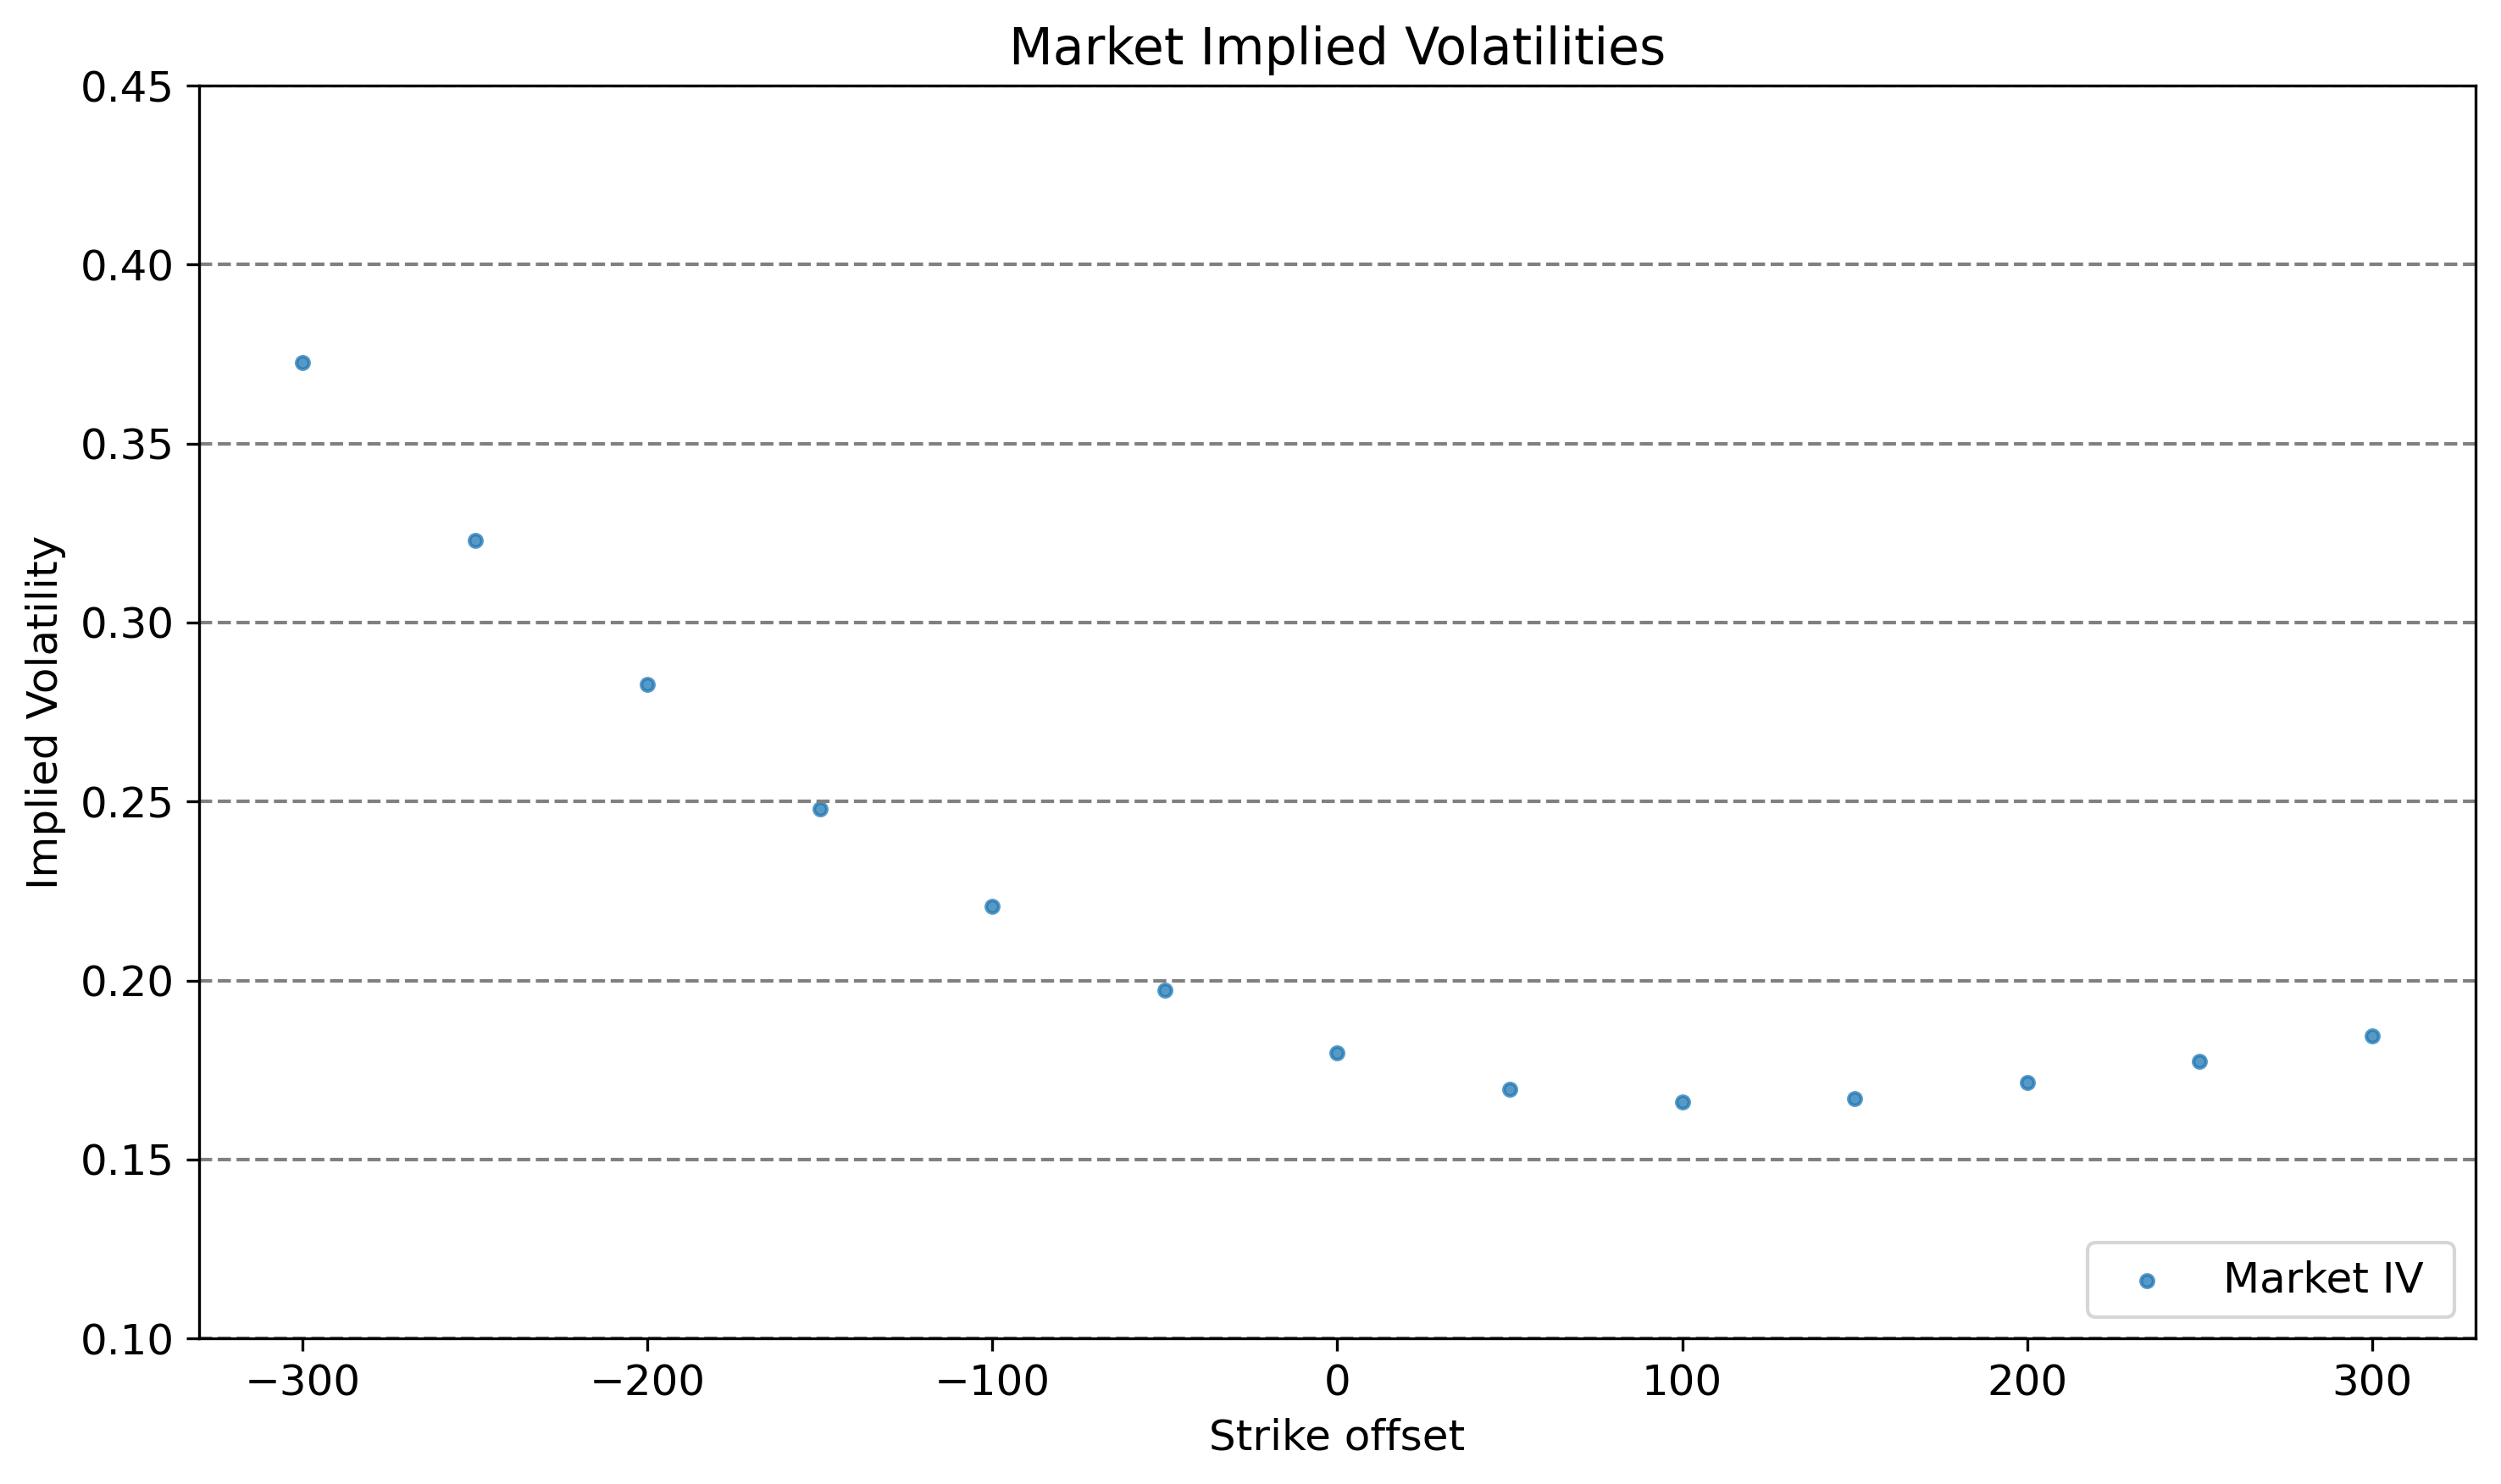

In [4]:
iv_plot = [{'label':'Market IV','x':K_swaption_offset,'y':iv_market, 's':50}]

plot.rates(iv_plot, title='Market Implied Volatilities', xlabel='Strike offset', ylabel='Implied Volatility')

#### (c) Using the implied volatility plot discuss whether the market is pricing swaptions according to Black’s model. If not, then what can be said about the distribution of the 2Y5Y forward par swap rate implied by the pricing measure chosen by the market? How does that distribution compare to the log normal distribution?
The observed implied volatility smile clearly indicates that the market is not pricing swaptions according to Black’s model. Instead, the market implies a distribution for the 2Y5Y forward par swap rate that exhibits skewness and heavier tails compared to the log-normal distribution assumed by Black’s model. This more complex distribution better captures the nuances in swaption pricing across different strike prices.

## Problem 2 - Fitting the SABR mode
We will now fit a SABR model to observed implied volatilities setting initial values $\tilde{\sigma}_0 = 0.055$,  $\tilde{\beta} = 0.5$,
$\tilde{\nu} = 0.48$ and $\tilde{\rho} = −0.25$ and the `nelder-mead` algorithm.

#### (a) Report the fitted parameter values $\hat{\sigma}_0$, $\hat{\beta}$, $\hat{\upsilon}$ and $\hat{\rho}$

In [5]:
param_0 = 0.055, 0.5, 0.48,-0.25
result = minimize(fid.fit_sabr_obj,param_0,method = 'nelder-mead',args = (iv_market,K,T[idx_exer],R_swap),options={'xatol': 1e-8,'disp': False})
print(f"Parameters from fit:\nsigma0: {result.x[0]}\nbeta: {result.x[1]}\nupsilon: {result.x[2]}\nrho: {result.x[3]}")

Parameters from fit:
sigma0: 0.03794210468649329
beta: 0.4941112287951783
upsilon: 0.5735906395611122
rho: -0.321759239869148


#### (b) Plot the observed and fitted values of implied volatilities as a function of $K_{offset}$. Do your fitted values fit the data?

In [6]:
sigma_0, beta, upsilon, rho = result.x
iv_fit, price_fit = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K[i],T[idx_exer],R_swap,sigma_0,beta,upsilon,rho,type = "call")
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T[idx_exer],K[i],S_swap,R_swap,type = "call")
print(f'fitted market implied volatilities: \n{iv_fit}')

fitted market implied volatilities: 
[0.37247181 0.32300549 0.28259141 0.24870706 0.22021729 0.196992
 0.179755   0.16947376 0.16597348 0.16746727 0.17183954 0.17761341
 0.1839624 ]


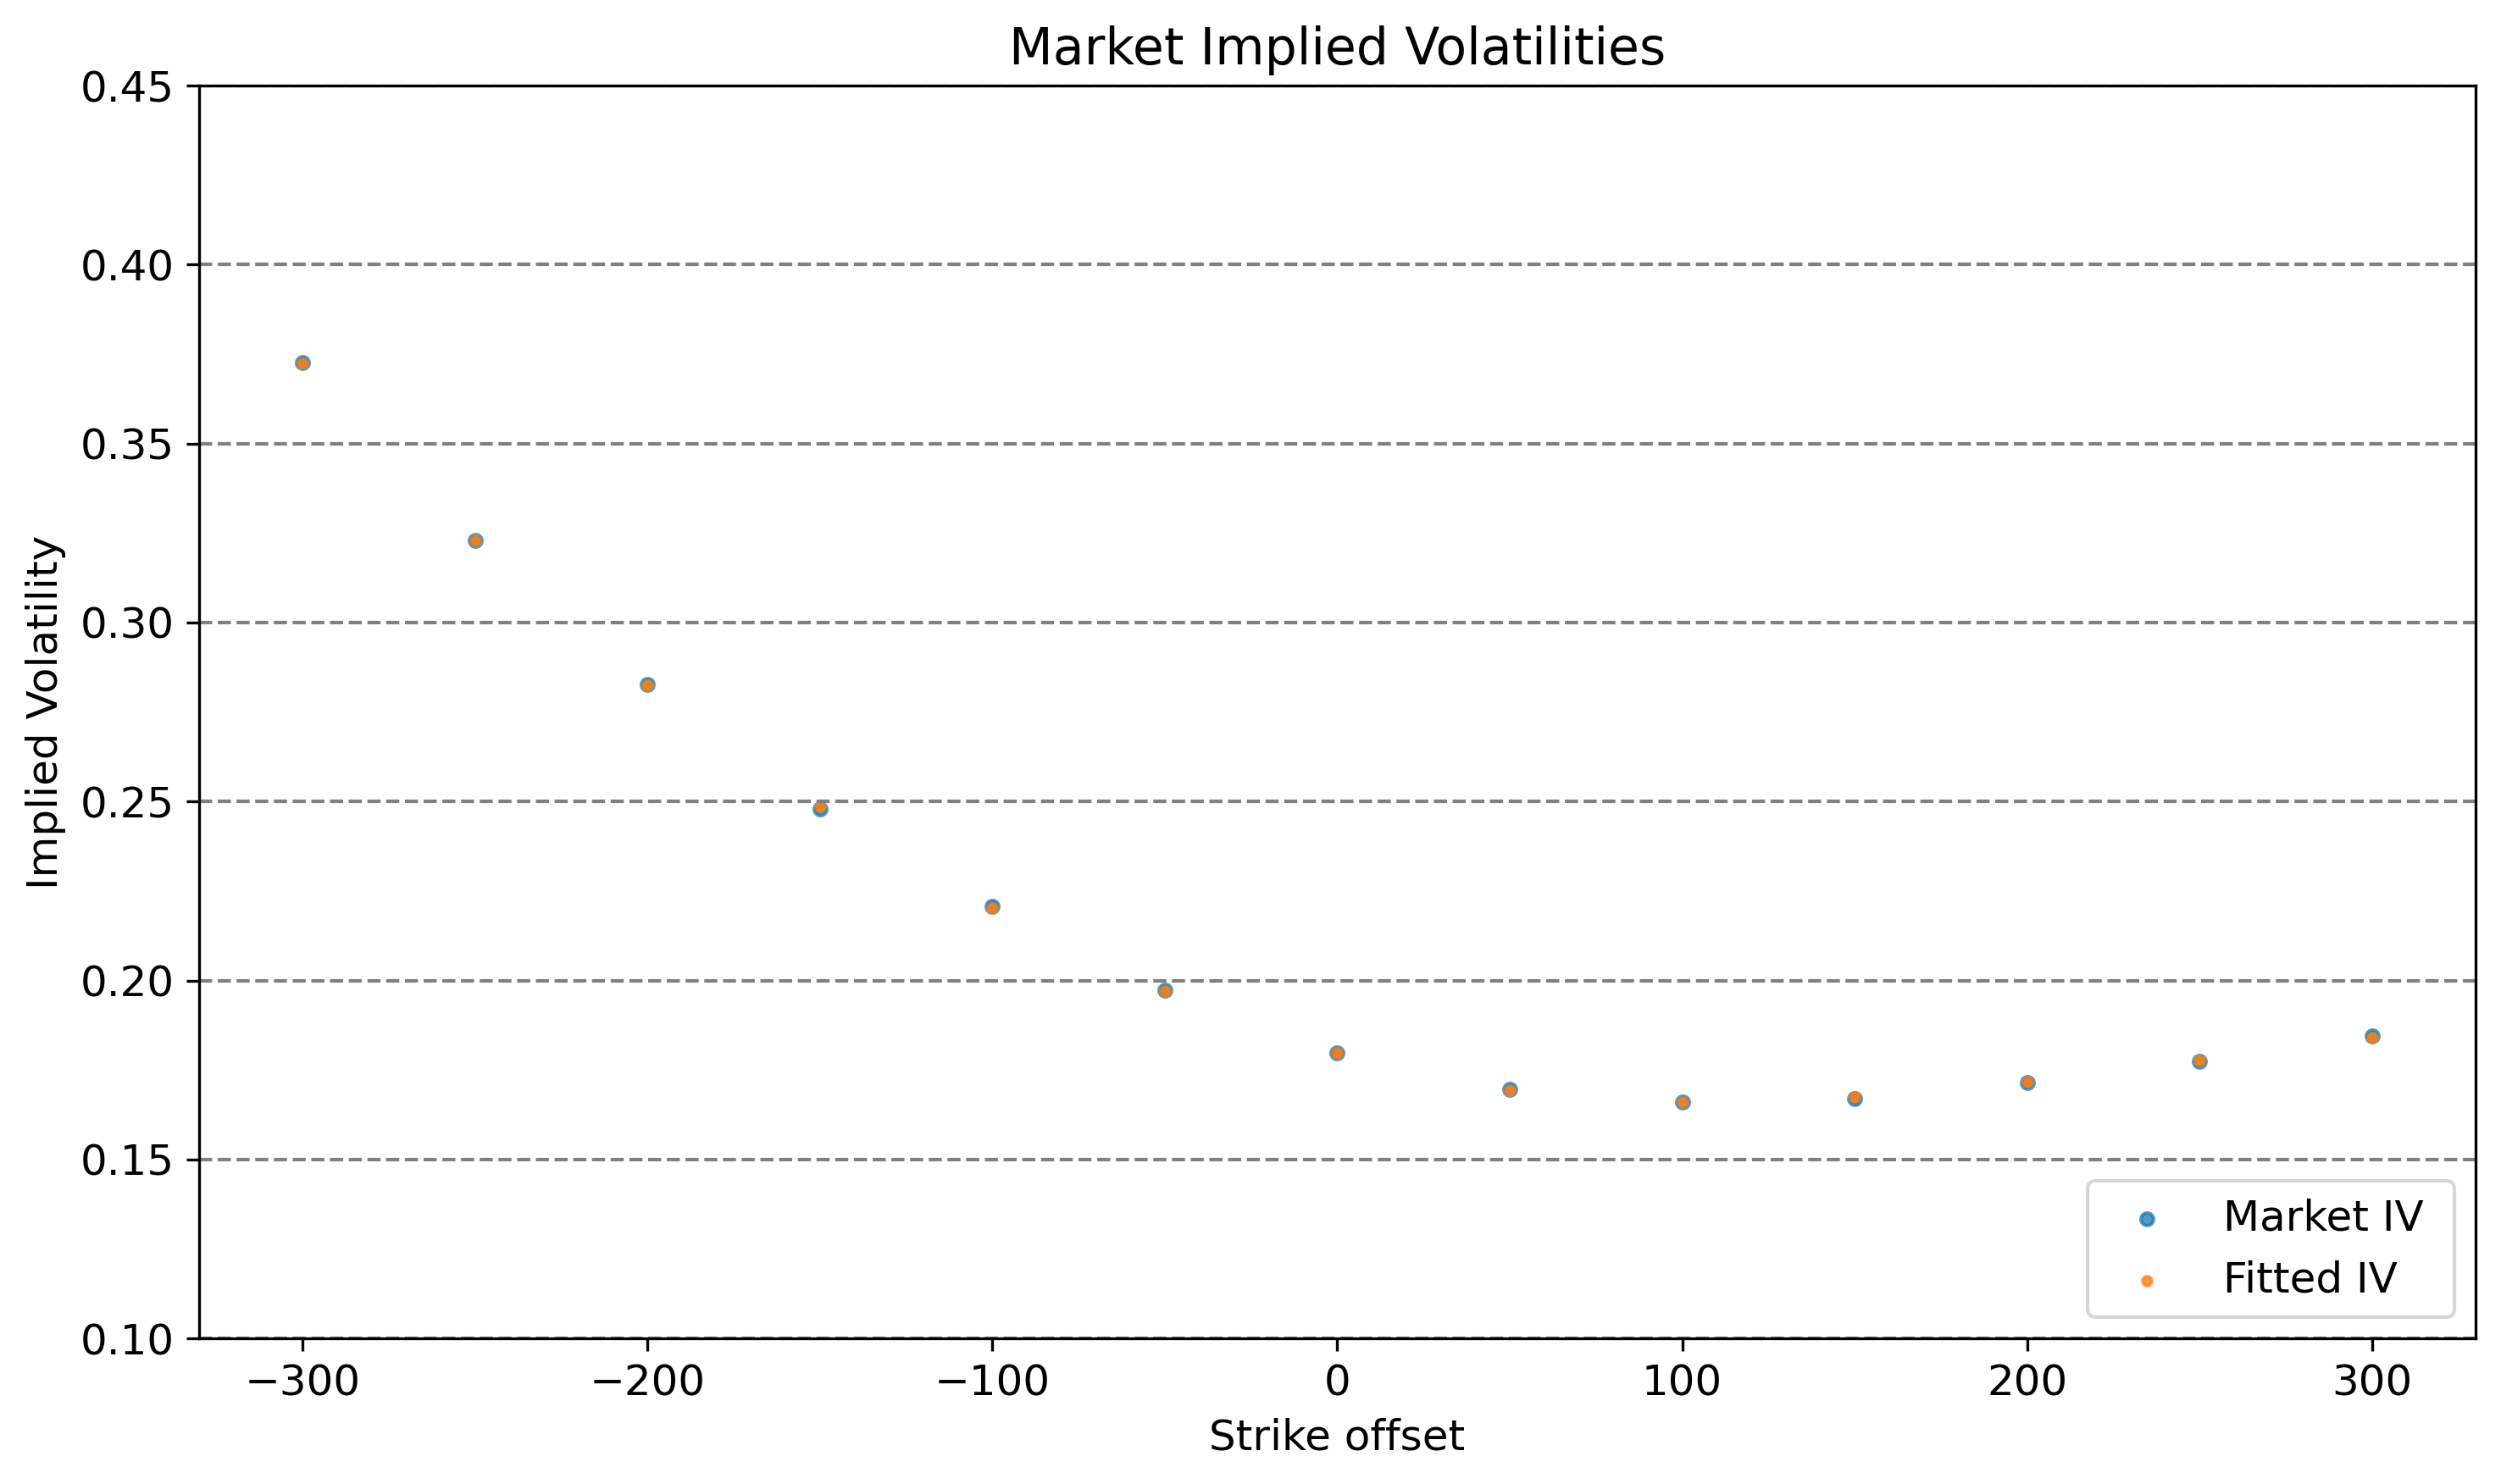

In [7]:
iv_plot.append({'label':'Fitted IV','x':K_swaption_offset,'y':iv_fit, 's':25})
plot.rates(iv_plot, title='Market Implied Volatilities', xlabel='Strike offset', ylabel='Implied Volatility')

As seen above the fitted implied volatility perfectly matches the data

#### Problem 3 - Simulating the forward rate in the SABR model
The forward rate, $F_t$, and the volatility $\sigma_t$ can be simulated in the SABR model using a simple Euler scheme. Denote by $M$, the number of steps in the simulation and index the time points in the simulation by $m$, $m \in\{0,1,2,...,M−1,M\}$ so that the time points will be $[t_0,t_1,...,t_{M−1},t_M] = [0,\delta,2\delta,...,T−\delta,T = \delta M]$ and hence the step in time will be of size $\delta = \frac{T}{M}$. The model can then be simulated using the following equations:
$$
\begin{split}
F_m = F_{m−1} + \sigma_{m−1} F_{m−1}^\beta \sqrt{\delta} Z_m^{(1)}, \quad F(0) = F_0 \\
\sigma_m = \sigma_{m−1} + \upsilon \sigma_{m−1} \sqrt{\delta}\left[\rho Z_m^{(1)} + \sqrt{1-\rho^2}Z_m^{(2)}\right], \quad \sigma(0) = \sigma_0
\end{split}
$$
where $Z_m^{(1)}$ and $Z_m^{(2)}$ are independent standard normal random variables.

We will now simulate a single trajectory of the 2Y5Y forward par swap rate and the volatility

#### (a) Plot the trajectories of the forward par swap rate and the volatility

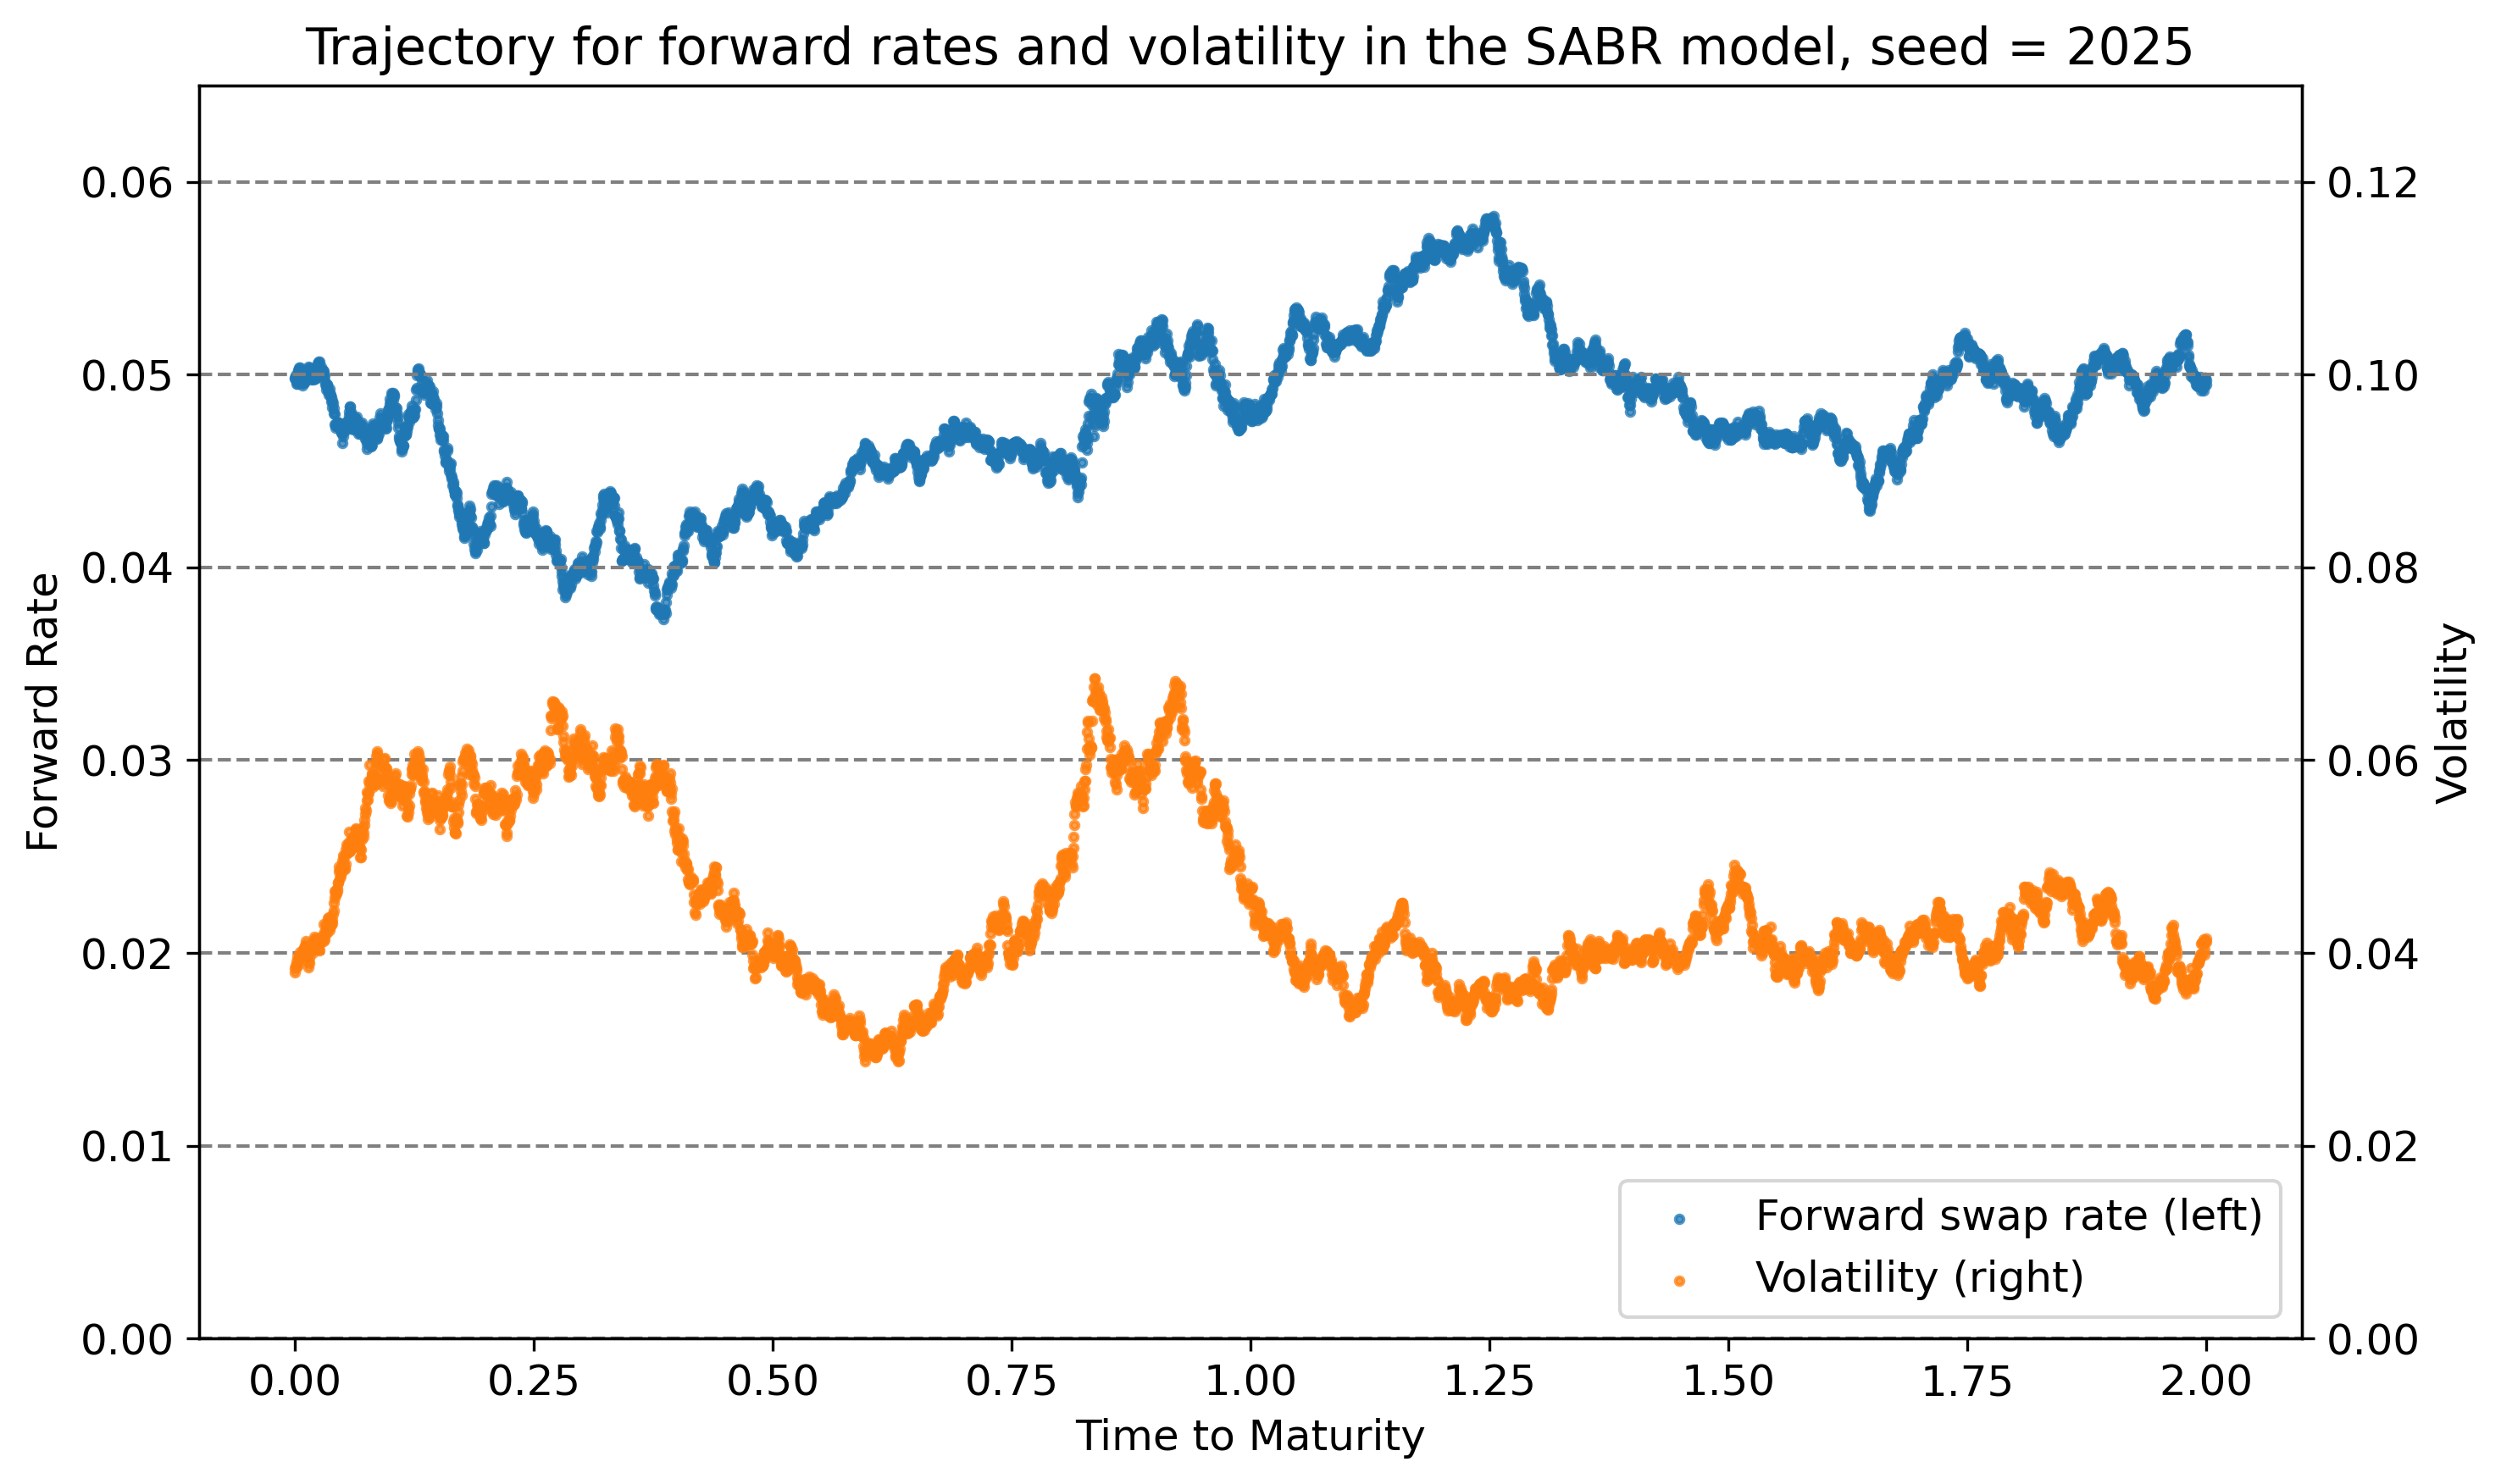

In [8]:
seed = 2025
np.random.seed(seed)
T_simul, M_simul = 2, 4000
F_simul, sigma_simul = fid.sabr_simul(R_swap,sigma_0,beta,upsilon,rho,M_simul,T_simul)
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])

left_axis = [{'label':'Forward swap rate','x':t_simul,'y':F_simul}]
right_axis = [{'label':'Volatility','x':t_simul,'y':sigma_simul}]



plot.rates(left_axis, right_axis, title=f'Trajectory for forward rates and volatility in the SABR model, seed = {seed}', ylabel='Forward Rate', ylabel_right='Volatility')

#### (b) Repeat the simulation for various values of the `seed`. Does the volatility behave in strange and perhaps undesired way depend on the choice of the seed

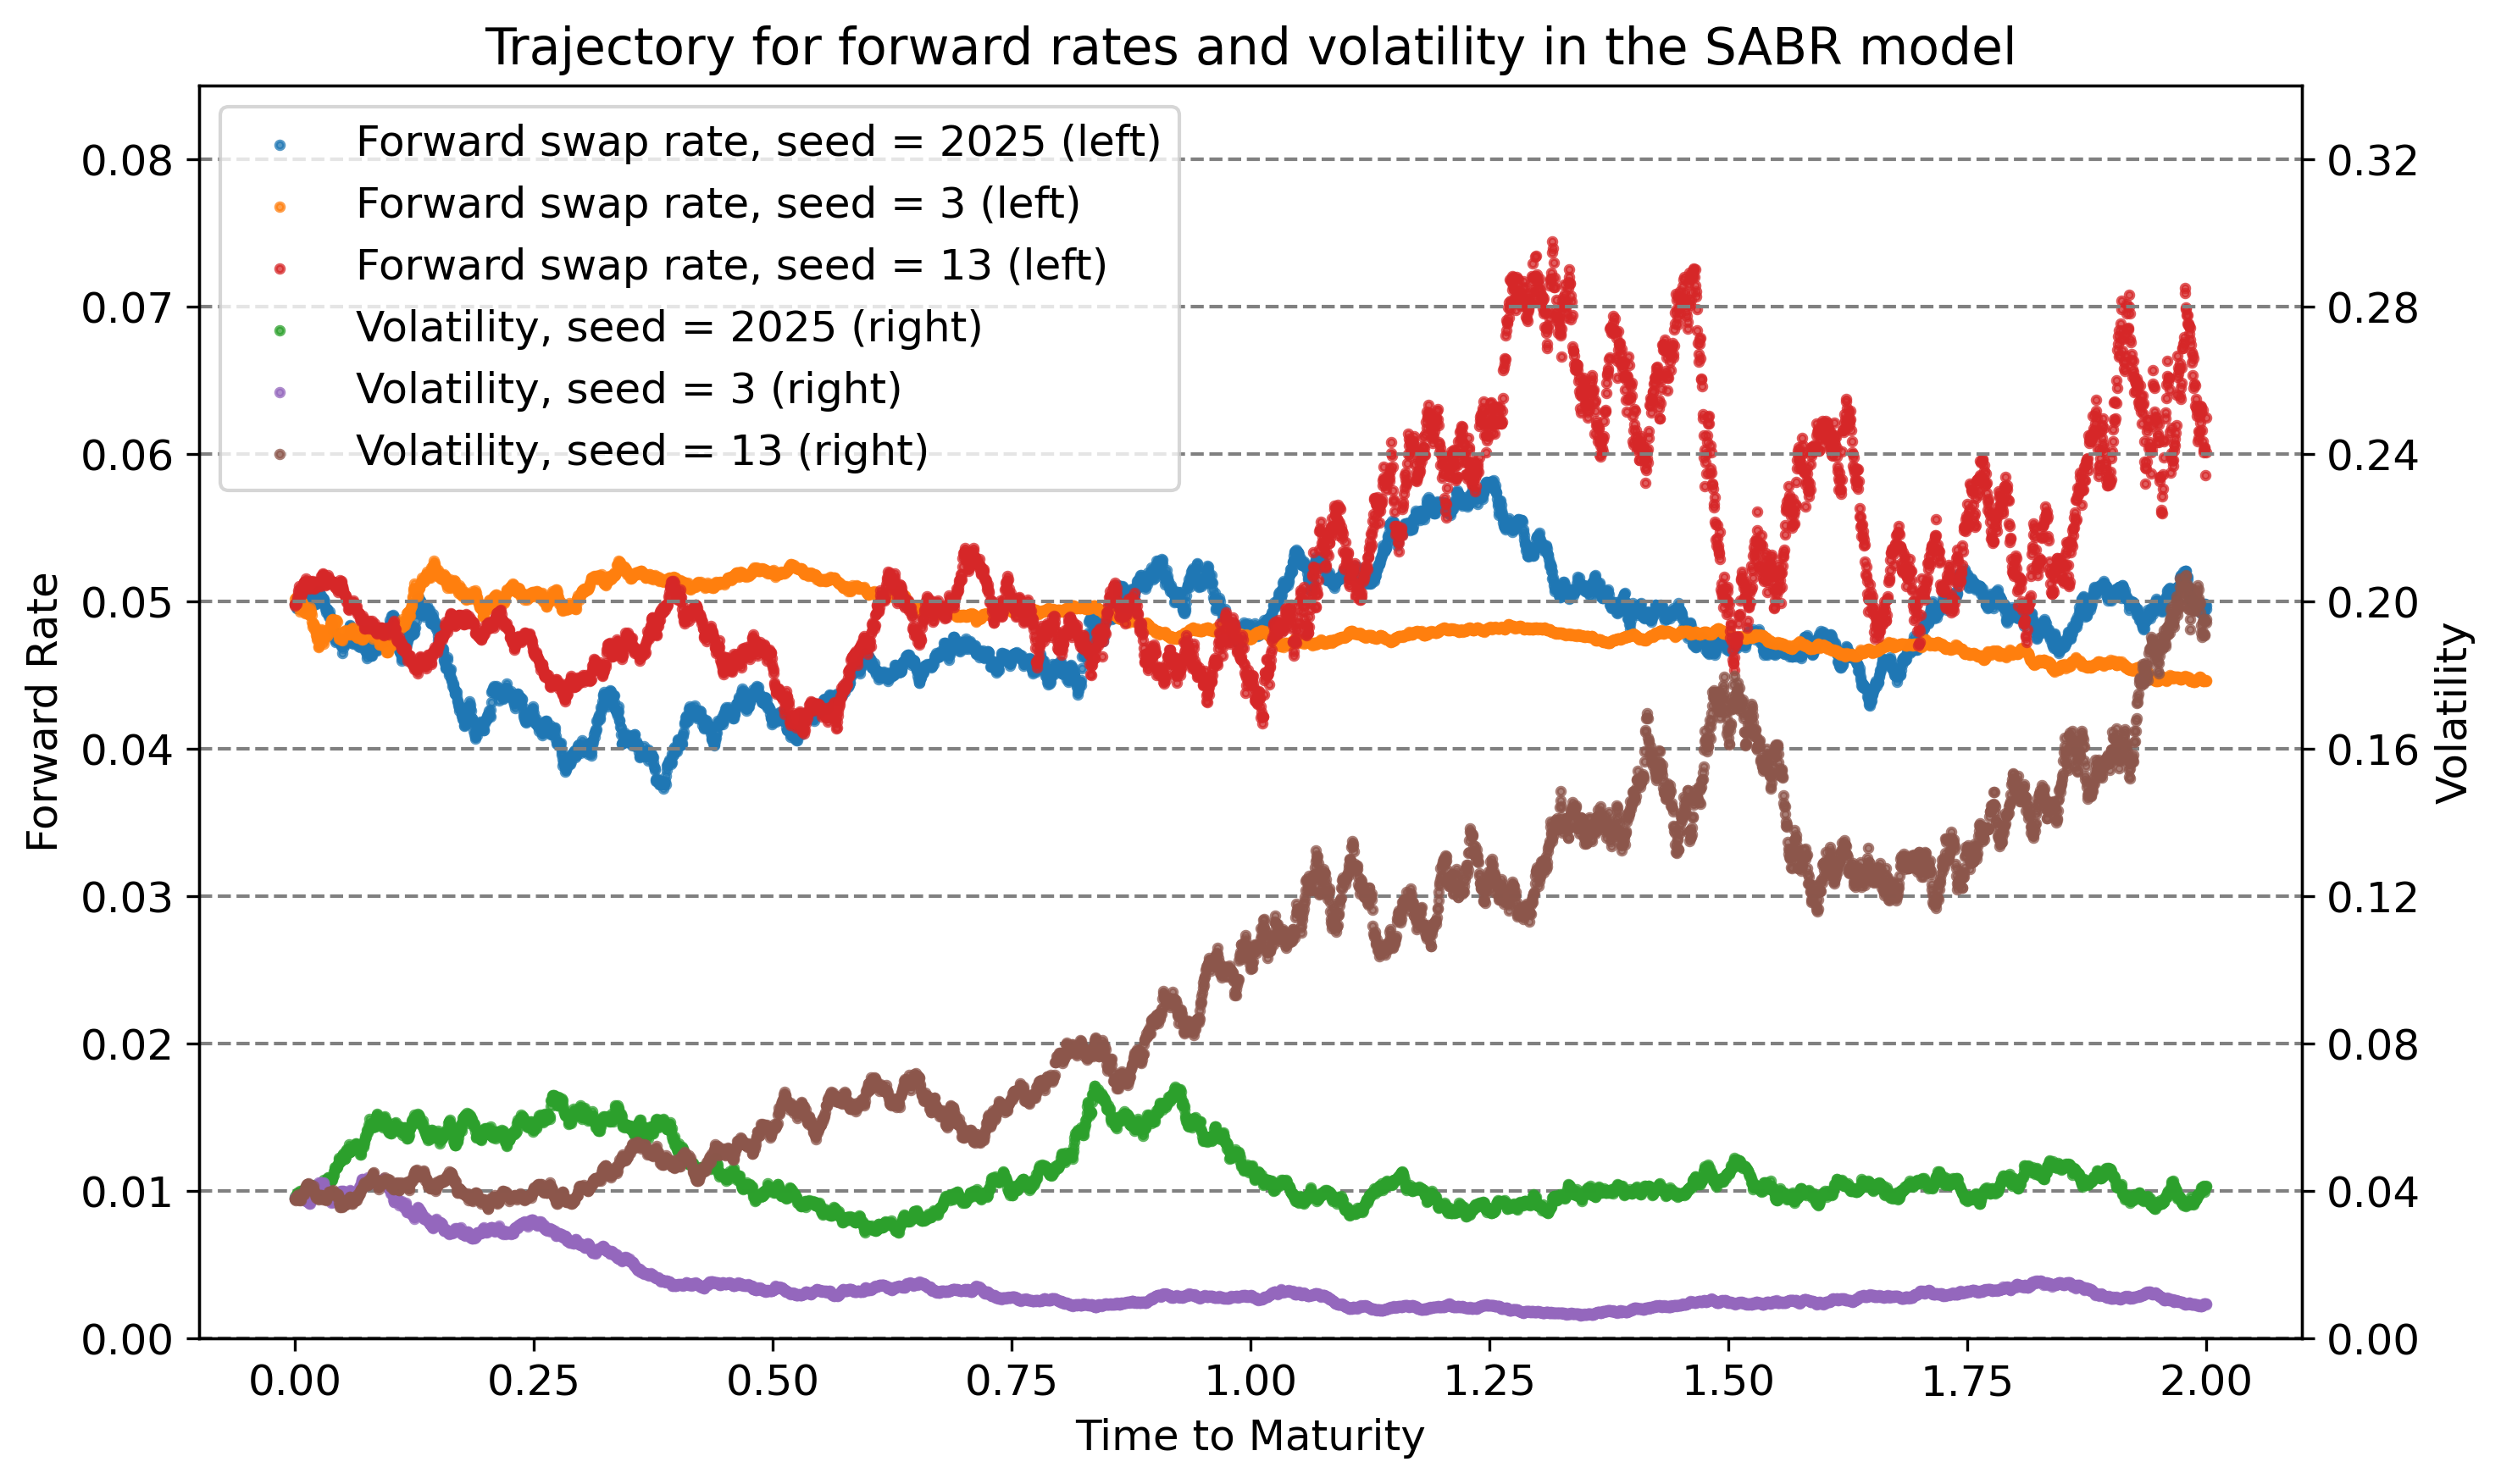

In [9]:
left_axis = []
right_axis = []
seeds = [2025, 3, 13]
for s in seeds:
    np.random.seed(s)
    T_simul, M_simul = 2, 4000
    F_simul, sigma_simul = fid.sabr_simul(R_swap,sigma_0,beta,upsilon,rho,M_simul,T_simul)
    t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])
    left_axis.append({'label':f'Forward swap rate, seed = {s}','x':t_simul,'y':F_simul})
    right_axis.append({'label':f'Volatility, seed = {s}','x':t_simul,'y':sigma_simul})

plot.rates(left_axis, right_axis, title=f'Trajectory for forward rates and volatility in the SABR model', ylabel='Forward Rate', ylabel_right='Volatility',legend_loc='upper left')

We see that for `seed = 13` the volatiltiy blows up while it for `seed = 4` goes to 0.

## Problem 4 - Pricing a digital option
Now, we will compute the price of a digital option in the SABR model. The digital option will be one that pays 1 unit of currency if the $5Y$ spot swap rate in exactly two years exceeds the $2Y5Y$ forward par swap rate observed right now $+75$ bps. So we have a strike $K = F_0 + 0.0075$

#### (a) Which measure is the SABR model defined under? And how does that affect your ability to compute the price of a maturity $T = 2$ derivative such as the digital option considered here. What can you do if you have to price a derivative with a different maturity?

The payoff $\chi(T_1)$ from a call option on the underlying asset $F$ with exercise date $T_1$ and strike $K$ is given by

$$
\chi(T_1) = \max\{F(T_1) - K, 0\} = \left[F(T_1)-K\right]_+
$$
The time $t$ price of a European call option with exercise $T_1 < T_2$ and settlement date $T_2$ then becomes
$$
\Pi(t;K) = P(t, T_2)\mathbb{E}^2\left[F(T_1)-K \mid \mathcal{F}_t\right]_+ \approx P(t, T_2)\left[F(t)\Phi(d_1) - K\Phi(d_2)\right]
$$
where $\mathbb{Q}^2$ is the measure under which $p(t,T_2)$ is nummeraire. $d_1$ and $d_2$ are 
$$
d_1 = \frac{1}{\sigma\sqrt{T_1 - t}}\left[\ln\left(\frac{F(0)}{K}\right) + \frac{1}{2}\sigma^2_b T_1\right], \quad d_2 = d_1 - \sigma_b\sqrt{T_1}
$$

***NB this is for a general call option, and should be adjusted to fit a digital option. See SABR.MOV or ChatGPT for more***

#### (b) Find the payoff function $\chi(T)$ and the discounted payoff function, $\tilde{\chi}(t)$ for the digital option.

$$ \chi(T_n) = \mathbb{1}_{R_n^N(T_n)>K} $$

$$\tilde{\chi}(T_n) = p(t,T_n)\mathbb{1}_{K>R_n^N(T_n)} = p(t,T_n)\chi(T_n)$$

Where $p(t,T_n)$ is the ZCB discount factor

#### (c) Using at least $M = 2000$ time steps and $N = 10000$ simulations, compute the price of the digital option

In [10]:
M_simul, T_digital = 2000, 2
N_simul = 10000
strike = R_swap + 75/10000
F_simul_digital, sigma_simul_digital = np.zeros([M_simul]), np.zeros([M_simul])
frac_ITM = np.zeros([N_simul]) # as this is a digital option its price is the fraction of the paths that are in the money
count = 0

np.random.seed(seed)
for n in range(0,N_simul):
    F_simul_digital, sigma_simul_digital = fid.sabr_simul(R_swap, sigma_0, beta, upsilon, rho, M_simul, T_digital)
    if F_simul_digital[-1] > strike:
        count += 1
    frac_ITM[n] = count/(n+1)
print(f"frac ITM: {frac_ITM[-1]}, price = {p[4]*frac_ITM[-1]}")

frac ITM: 0.251, price = 0.23256414036


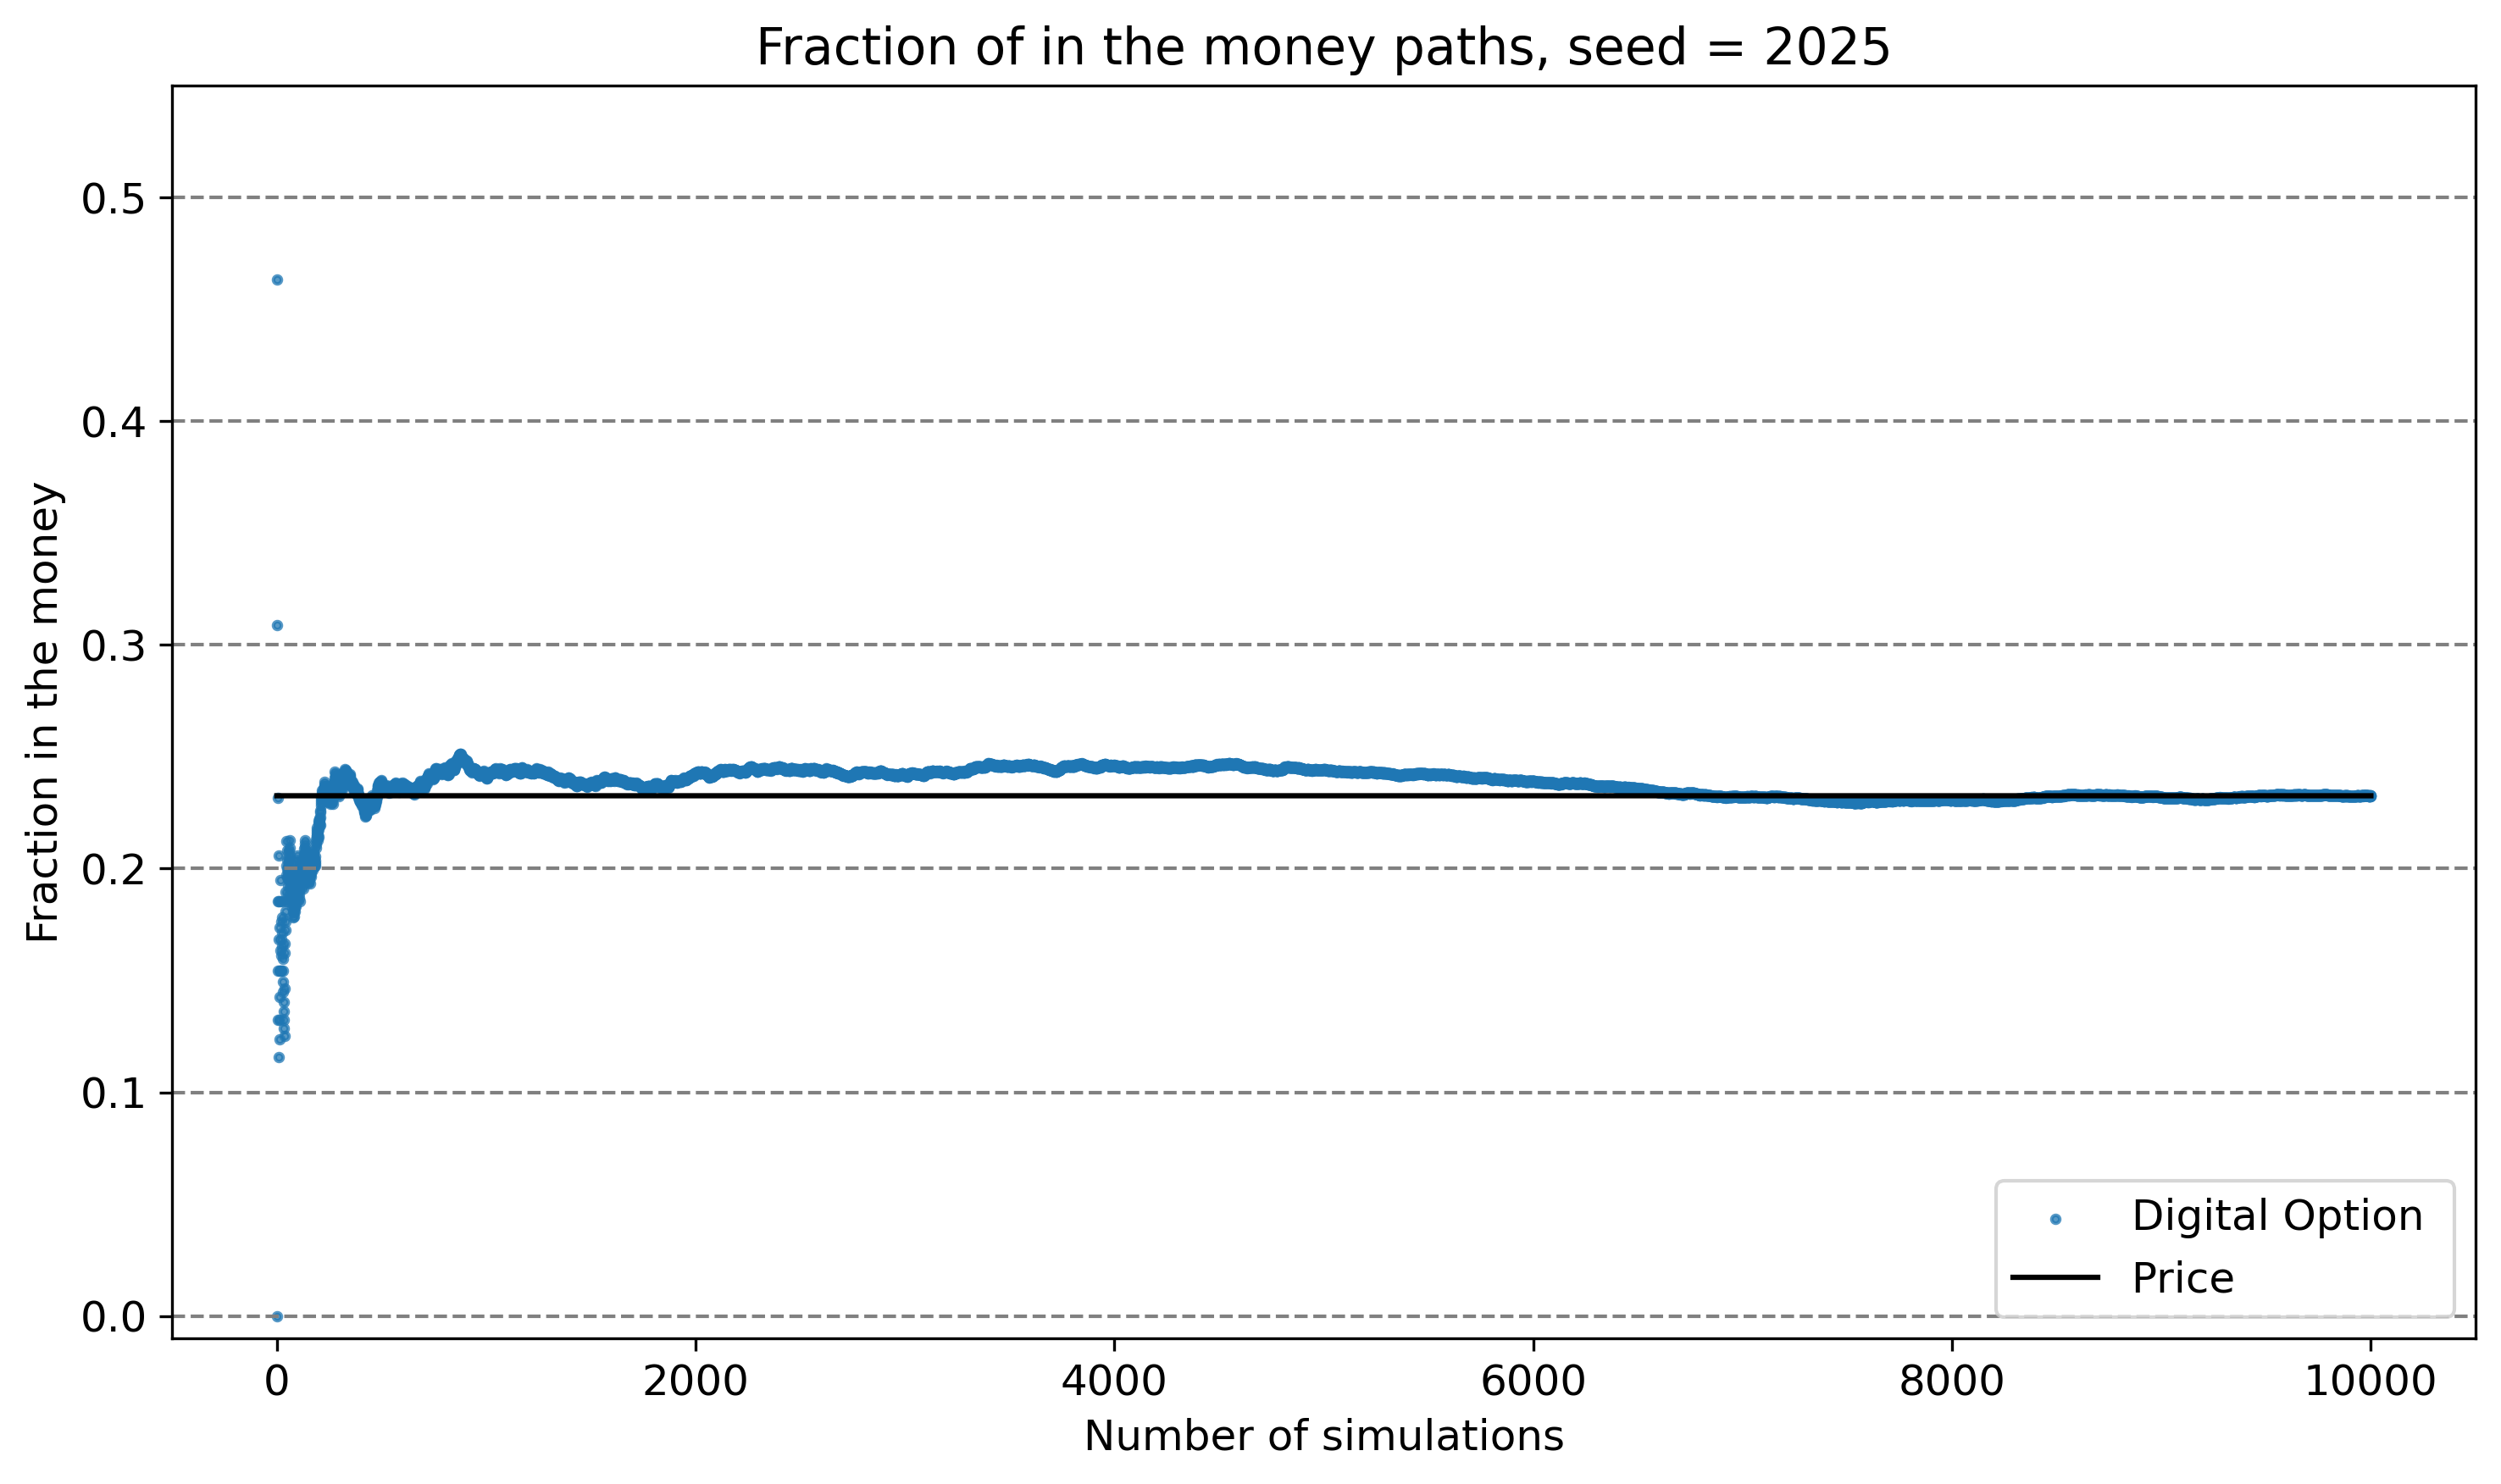

In [11]:
digi_plot = [{'label':'Digital Option','x':np.arange(1,N_simul+1),'y':p[4]*frac_ITM},
             {'label':'Price','x':np.arange(1,N_simul+1),'y':p[4]*frac_ITM[-1]*np.ones(N_simul), 'type':'line', 'color':'black'}]
plot.rates(digi_plot, title=f'Fraction of in the money paths, seed = {seed}', xlabel='Number of simulations', ylabel='Fraction in the money')

# Problem 5 - Risk Management in the SABR model
Imagine you have a long position in the $K_{offset} = 150$ $2Y5Y$ payer swaption and you need to assess how you are exposed to changes in the SABR model parameters. Do this by computing the change in dollar value (DV) in the following cases

#### (a) If $\sigma_0$ falls by $0.001$

In [12]:
idx_position = 9
sigma_0_bump = sigma_0 - 0.001
iv_sigma_0 = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0_bump,beta,upsilon,rho,type = "call")
price_sigma_0 = fid.black_swaption_price(iv_sigma_0,T[idx_exer],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping sigma_0: {price_sigma_0}, diff: {price_sigma_0-price_market[idx_position]}")

price after bumping sigma_0: 0.0033917683612518213, diff: -0.0002250516387481789


#### (b) If the entire spot rate curve drops by $1$ bp

In [13]:
R = fid.spot_rates_from_zcb_prices(T,p)
R_bump = R - 0.0001*np.ones([M])
p_bump = fid.zcb_prices_from_spot_rates(T,R_bump)
S_bump = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_bump += alpha*p_bump[i]
R_swap_bump = (p_bump[idx_exer] - p_bump[idx_mat])/S_bump
sigma_delta = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap_bump,sigma_0,beta,upsilon,rho,type = "call")
price_delta = fid.black_swaption_price(sigma_delta,T[idx_exer],K[idx_position],S_bump,R_swap_bump,type = "call")
print(f"price after bumping spot rates: {price_delta}, diff: {price_delta-price_market[idx_position]} in percent :{(price_delta-price_market[idx_position])/price_market[idx_position]}")

price after bumping spot rates: 0.003608516695797702, diff: -8.303304202298203e-06 in percent :-0.0022957471486826004
